# Introduction and setup

Import neccessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import itertools
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Helper functions.

In [2]:
def parse_datetime(date, time):
    return datetime.strptime(date + ' ' + time, '%d.%m.%Y %H:%M')

def parse_time(time):
    return datetime.strptime(time, '%H:%M').time()

def add_datetime_column(df):
    df['datetime'] = df.apply(lambda x: parse_datetime(x.Date, x.Timestamp), axis=1)
    
def add_time_column(df):
    df['time'] = df.apply(lambda x: parse_time(x.Timestamp), axis=1)
    
def set_concise_formatter(ax):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

Read in the data. Subject 1 = Behrad, Subject 2 = Gregor, Subject 3 = Kaarel

In [3]:
reaction_subject_1_data, reaction_subject_2_data, reaction_subject_3_data = (
    pd.read_csv('data/reaction_subject_1.csv'),
    pd.read_csv('data/reaction_subject_2.csv'),
    pd.read_csv('data/reaction_subject_3.csv')
)

visual_subject_1_data, visual_subject_2_data, visual_subject_3_data = (
    pd.read_csv('data/visual_subject_1.csv'),
    pd.read_csv('data/visual_subject_2.csv'),
    pd.read_csv('data/visual_subject_3.csv')
)

typing_subject_1_data, typing_subject_2_data, typing_subject_3_data = (
    pd.read_csv('data/typing_subject_1.csv'),
    pd.read_csv('data/typing_subject_2.csv'),
    pd.read_csv('data/typing_subject_3.csv')
)

# Add 'datetime' column to dataframes
add_datetime_column(reaction_subject_1_data)
add_datetime_column(reaction_subject_2_data)
add_datetime_column(reaction_subject_3_data)

add_datetime_column(visual_subject_1_data)
add_datetime_column(visual_subject_2_data)
add_datetime_column(visual_subject_3_data)

add_datetime_column(typing_subject_1_data)
add_datetime_column(typing_subject_2_data)
add_datetime_column(typing_subject_3_data)

# Add 'time' column to dataframes
add_time_column(reaction_subject_1_data)
add_time_column(reaction_subject_2_data)
add_time_column(reaction_subject_3_data)

add_time_column(visual_subject_1_data)
add_time_column(visual_subject_2_data)
add_time_column(visual_subject_3_data)

add_time_column(typing_subject_1_data)
add_time_column(typing_subject_2_data)
add_time_column(typing_subject_3_data)

# Create data dictionary
data = {
    'reaction': [reaction_subject_1_data, reaction_subject_2_data, reaction_subject_3_data],
    'visual': [visual_subject_1_data, visual_subject_2_data, visual_subject_3_data],
    'typing': [typing_subject_1_data, typing_subject_2_data, typing_subject_3_data]
}

Let's have look at the shapes of dataframes and total data points all together. Also lets plot them on scatter plots.

In [4]:
def print_shapes(test_type):
    print(test_type + " shapes:", list(map(lambda x: x.shape, data[test_type])))

In [5]:
print_shapes('reaction')
print_shapes('visual')
print_shapes('typing')

reaction shapes: [(50, 5), (29, 5), (38, 5)]
visual shapes: [(60, 5), (29, 5), (38, 5)]
typing shapes: [(60, 5), (33, 5), (38, 5)]


In [6]:
total_df = pd.concat(list(itertools.chain(*data.values())), sort=False)
print("Total data points shape:", total_df.shape)
total_df.head()

Total data points shape: (375, 5)


,Date,Timestamp,result,datetime,time
0,18.11.2019,18:57,267,2019-11-18 18:57:00,18:57:00
1,18.11.2019,12:29,268,2019-11-18 12:29:00,12:29:00
2,18.11.2019,18:06,282,2019-11-18 18:06:00,18:06:00
3,18.11.2019,12:08,272,2019-11-18 12:08:00,12:08:00
4,18.11.2019,14:35,276,2019-11-18 14:35:00,14:35:00


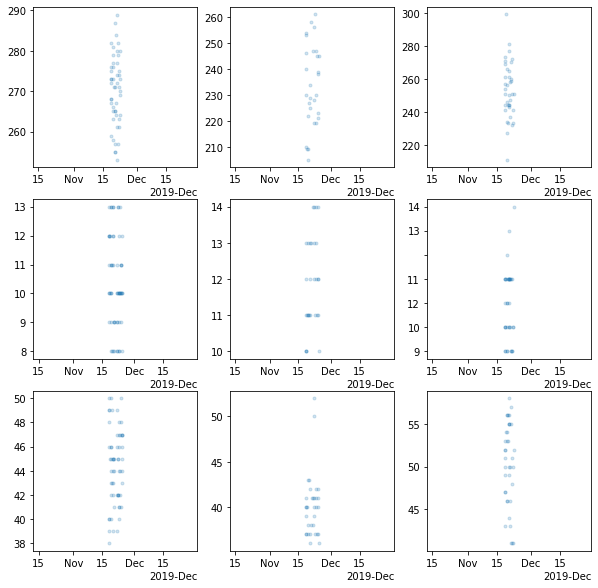

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, (test_type, ax) in enumerate(zip(np.repeat(['reaction', 'visual', 'typing'], 3), itertools.chain(*axs))):
    d = data[test_type][i % 3]
    ax.scatter(d.datetime, d.result, marker='.', alpha=0.2)
    set_concise_formatter(ax)
    # TODO: Add axises and plot titles
        
plt.show()

## Performance throughout the day

First, let's have look at two-hour interval average performance of **reaction** time test of all the subjects.

In [8]:
# Combine all subjects reaction data into single dataframe
reaction_data = pd.concat([reaction_subject_1_data, reaction_subject_2_data, reaction_subject_3_data])

# Set 'datetime' column as dateframe index for making it possible resample based on it
reaction_data.set_index(reaction_data['datetime'], inplace=True)
reaction_data = reaction_data.loc['2019-11-18':'2019-11-22'] # Disgarding data from 23rd and 24th November since only present for one subject

two_hour_interval_result_means = reaction_data.resample('2H').mean().dropna() # Two-hour interval 'result' means, dropping NaN results
daily_result_means = reaction_data.resample('D').mean() # Daily 'result' means

Plot two-hour frequency averages for each day.

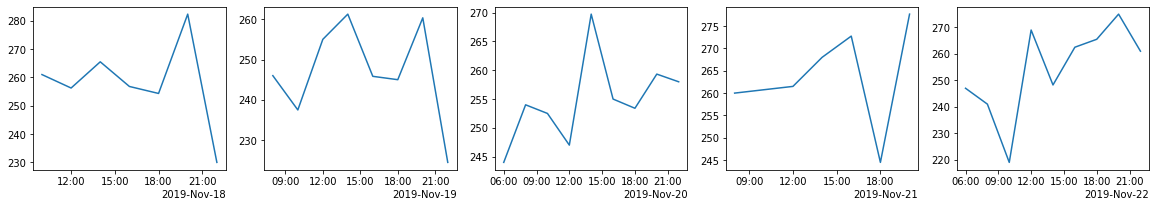

In [9]:
fig, axs = plt.subplots(1, 5, figsize=(20,3))
for day, ax in zip(range(18, 23), axs):
    data = two_hour_interval_result_means.loc['2019-11-' + str(day)] # Get data for single day
    ax.plot(data.index, data.result)
    for ax in axs:
        set_concise_formatter(ax)
        
plt.show()

From the charts above it can be seen that reaction time got better in the evening. There are spikes at evening on all days except 20 Nov. It seems that in the morning brain is not yet at its best performance and it gets better as the day progresses.

Inorder to validate this lets discard the dates and look at the results as they happened on a single day.

In [13]:
reaction_data['time'] = reaction_data.apply(lambda x: datetime.strptime(x.Timestamp, '%H:%M'), axis=1)
reaction_data.set_index(reaction_data['time'], inplace=True)
hourly_data = reaction_data.resample('2H').mean().dropna()
hourly_data

,result
time,
1900-01-01 06:00:00,245.500000
1900-01-01 08:00:00,251.000000
1900-01-01 10:00:00,243.333333
1900-01-01 12:00:00,256.000000
1900-01-01 14:00:00,262.818182
1900-01-01 16:00:00,257.000000
1900-01-01 18:00:00,254.421053
1900-01-01 20:00:00,270.642857
1900-01-01 22:00:00,242.666667


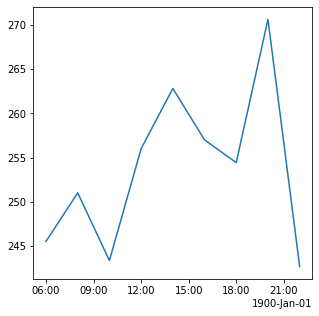

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(hourly_data.index, hourly_data.result)
set_concise_formatter(ax)
plt.show()